In [1]:
from pathlib import Path
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from data_loader import *
from test import *



# pre-process
def pre_proc(tau, block):
    '''1-exp(-tau)'''
    tau   = np.array(tau)
    block = np.array(block)
    return (1-np.exp(-1*tau), block)

def toF_proc(tau):
    tau   = np.array(tau)
    return (1-tau)



# Path and data file name
folder  = Path.cwd().parent / 'Illustris3'
DM_name = ['DMdelta_Illustris3_L75_N600_v2.fits', 
            'vx_cic_Illustris3_L75_N600.fits',
            'vy_cic_Illustris3_L75_N600.fits',
            'vz_cic_Illustris3_L75_N600.fits']
ske_name = 'spectra_Illustris3_N600.npy'



# hyper parameters
train_size = np.array([9, 9, 67]) # x, y, z respctively
test_batch = 50
localtime_n = ['2019-11-03 03:45:29', '2019-11-04 14:30:32']

In [6]:
test_outp_i = np.random.rand(100)

In [7]:
vaxis = np.arange(600)
test_outp_i = np.random.rand(600)
test_ske_i  = np.random.rand(600)
rvaxis = np.random.rand(15)
onePS_outp = np.random.rand(15)
onePS_test = np.random.rand(15)
accuracy_i = 0.5
rela_err_i = 0.5

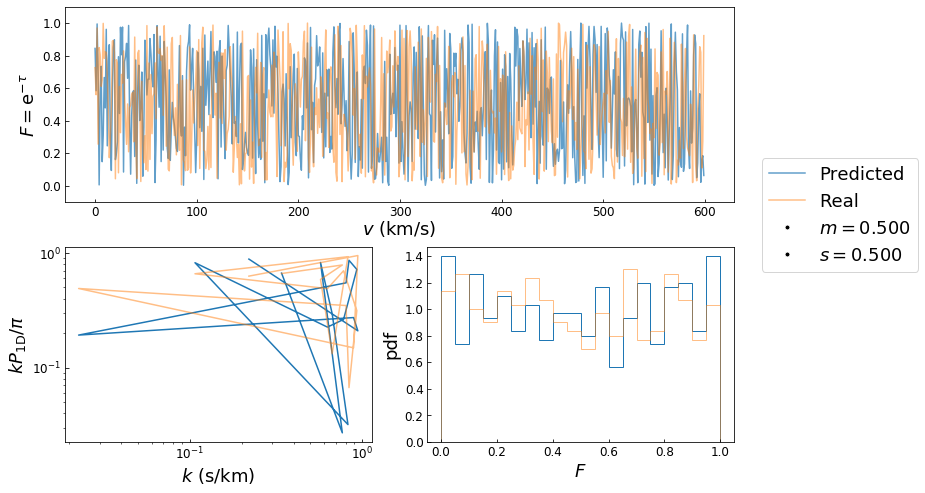

In [28]:
fig = plt.figure(figsize=(12,8))
# plot skewers in F
axes1 = fig.add_subplot(2,1,1)
p1, = axes1.plot(vaxis, test_outp_i, label='Predicted', alpha=0.7 )
p2, = axes1.plot(vaxis, test_ske_i, label='Real', alpha=0.5 )
axes1.set_xlabel(r'$v$ (km/s)', fontsize=18, labelpad=0)
axes1.set_ylabel(r'$F = \mathrm{e}^{-\tau}$', fontsize=18)
axes1.set_ylim([-0.1, 1.1])
axes1.tick_params(labelsize=12, direction='in')
#axes1.legend(fontsize=18, bbox_to_anchor=(1.30, 0.75))

# plot 1DPS
axes2 = fig.add_subplot(2,2,3)
axes2.plot(rvaxis, onePS_outp, label='Predicted')
axes2.plot(rvaxis, onePS_test, label='Real', alpha=0.5)
axes2.set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=18)
axes2.set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=18)
axes2.set_xscale('log')
axes2.set_yscale('log')
axes2.tick_params(labelsize=12, direction='in')

# plot pdf of F
axes3 = fig.add_subplot(2,2,4)
axes3.hist(test_outp_i, bins=np.arange(0,1.05,0.05),
          density=True, histtype='step', label='Predicted')
axes3.hist(test_ske_i, bins=np.arange(0,1.05,0.05),
          density=True, histtype='step', label='Real', alpha=0.5)
axes3.set_xlabel(r'$F$', fontsize=18)
axes3.set_ylabel(r'pdf', fontsize=18)
axes3.set_xlim([-0.05, 1.05])
axes3.tick_params(labelsize=12, direction='in')
customs = [p1, p2, 
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
axes3.legend(customs, [p1.get_label(), p2.get_label(), '$m=%.3f$'%accuracy_i,
                    '$s=%.3f$'%rela_err_i], fontsize=18, bbox_to_anchor=(1.06,1.5))
plt.subplots_adjust(wspace=0.18, hspace=0.23)

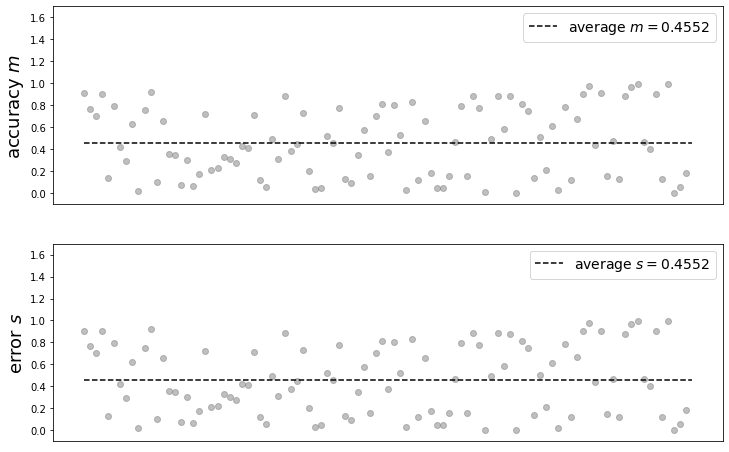

In [4]:
fig, axes = plt.subplots(2,1,figsize=(12,8))
arr = np.random.rand(100)
axes[0].scatter(np.arange(100), arr, alpha=0.5, color='grey')
p1 = axes[0].hlines(y=arr.mean(), xmin=0, xmax=100, linestyle='--')
axes[0].set_xticks([])
axes[0].set_ylim([-0.1, 1.7])
axes[0].set_ylabel('accuracy $m$', fontsize=18)
customs = [p1]
axes[0].legend(customs, ['average $m=%.4f$'%arr.mean()], fontsize=14, loc=1)


axes[1].scatter(np.arange(100), arr, alpha=0.5, color='grey')
p2 = axes[1].hlines(y=arr.mean(), xmin=0, xmax=100, linestyle='--')
axes[1].set_xticks([])
axes[1].set_ylim([-0.1, 1.7])
axes[1].set_ylabel('error $s$', fontsize=18)
customs = [p2]
axes[1].legend(customs, ['average $s=%.4f$'%arr.mean()], fontsize=14, loc=1)

#plt.savefig(folder_outp / ('average.png'), dpi=200, bbox_inches='tight') 

In [2]:
#for localtime_i in localtime_n:
localtime_i = '2019-11-03 03:45:29'
localtime = time.strptime(localtime_i, '%Y-%m-%d %H:%M:%S')
if ~(train_size%2).all():
    raise ValueError('train size scannot be even.')



# device used to train the model
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Using device:', device)



# load dark matter data
print('Loading dark matter...')
DM_general = load_DM(folder, DM_name)
# basic paramters
DM_param.pix  = len(DM_general[0])
DM_param.len  = 75*1000 # in kpc/h
DM_param.reso = DM_param.len / DM_param.pix # in kpc/h
# test
if DM_general.shape[1]<train_size.min():
    raise ValueError('DarkMatter cube size',
        DM_general.shape, 'is too small for train size', train_size, '.')
DM_general = torch.tensor(DM_general).float()


# load skewers
print('Loading skewers...')
ske, block = load_skewers(folder, ske_name, DM_param)
# basic parameters
ske_len = ske.shape[1]

Using device: cuda:1
Loading dark matter...
Loading skewers...


In [3]:
# divide the sample to training, validation set, and test set.
print('Setting test set...')
with open("id_seperate/id_seperate_%s.txt"\
          %time.strftime("%Y-%m-%d_%H:%M:%S", localtime), "r") as f:
    aa = f.readlines()
    id_seperate = np.array(list(aa[0][::3])).astype('int')
    del aa
f.close()

test_ske, test_block = load_test(ske, block, id_seperate, test_batch)
test_ske, test_block = pre_proc(test_ske, test_block)
test_ske = torch.FloatTensor(test_ske)
del id_seperate


# load model
model = get_residual_network().float().to(device)
model.load_state_dict(torch.load('params/params_%s.pkl'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
# model.load_state_dict(torch.load('params/HyPhy_%s.pkl'\
#       %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))



# loss
criterion = nn.SmoothL1Loss()


# record starr time
start_time = time.time()


# start test
print('Begin testing...')
test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                        test_batch, train_size, model, criterion, device, start_time)

print("Test Summary: ")
print("\tTest loss: {}".format(test_losses))

# restore test skewers
test_ske   = test_ske.numpy().reshape(-1, ske_len)
test_ske   = pre_proc_r(test_ske)
test_outp  = pre_proc_r(test_outp)
test_block = test_block.reshape(-1, DM_param.pix, 3)

Setting test set...
Begin testing...
Step [100/4800] Loss: 0.0026, Time: 5.5037
Step [200/4800] Loss: 0.0161, Time: 11.0532
Step [300/4800] Loss: 0.0095, Time: 16.5880
Step [400/4800] Loss: 0.0051, Time: 22.2648
Step [500/4800] Loss: 0.0016, Time: 27.8083
Step [600/4800] Loss: 0.0041, Time: 33.2595
Step [700/4800] Loss: 0.0017, Time: 38.6858
Step [800/4800] Loss: 0.0013, Time: 44.1464
Step [900/4800] Loss: 0.0002, Time: 49.5539
Step [1000/4800] Loss: 0.0260, Time: 54.9229
Step [1100/4800] Loss: 0.0055, Time: 60.2734
Step [1200/4800] Loss: 0.0002, Time: 65.5814
Step [1300/4800] Loss: 0.0045, Time: 70.9415
Step [1400/4800] Loss: 0.0079, Time: 76.2481
Step [1500/4800] Loss: 0.0396, Time: 81.7243
Step [1600/4800] Loss: 0.0004, Time: 87.2426
Step [1700/4800] Loss: 0.0015, Time: 92.5731
Step [1800/4800] Loss: 0.0002, Time: 98.0066
Step [1900/4800] Loss: 0.0032, Time: 103.3919
Step [2000/4800] Loss: 0.0013, Time: 108.7641
Step [2100/4800] Loss: 0.0045, Time: 114.1482
Step [2200/4800] Loss: 0.

In [6]:
print('Plotting example skewers...')
# generate comparison images
folder_outp = Path.cwd()/'test_figs'/('%s'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
if not os.path.exists(folder_outp):
    os.makedirs(folder_outp)

from scipy import constants as C
v_end  = 0.02514741843009228 * C.speed_of_light / 1e3
vaxis  = np.arange(0, v_end, v_end/600)

nrange = min(len(test_ske), 50)
test_sp = np.arange(len(test_ske))
np.random.seed(99)
np.random.shuffle(test_sp)
test_sp1 = test_sp[:int(nrange)].astype('int')
test_sp2 = test_sp[int(nrange):].astype('int')

accuracy = AverageMeter()
rela_err = AverageMeter()

Plotting example skewers...


In [10]:
i = 0
ii = test_sp1[i]

In [11]:
test_block_i = test_block[ii, 0]
test_outp_i = test_outp[ii]
test_ske_i = test_ske[ii]
test_DM_i = DM_general[0, test_block[ii,0,0], test_block[ii,0,1], :].numpy()

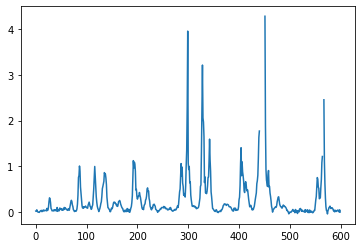

In [18]:
plt.plot(test_outp_i)

In [ ]:

#loop
for i, ii in enumerate(test_sp1):
    print('Plotting {}/{}, x{}y{}.png...'\
          .format((i+1), nrange, test_block[ii,0,0], test_block[ii,0,1]))

    test_block_i = test_block[ii, 0]
    test_outp_i = test_outp[ii]
    test_ske_i = test_ske[ii]
    test_DM_i = DM_general[0, test_block[ii,0,0], test_block[ii,0,1], :].numpy()

    accuracy_i, rela_err_i = test_plot(test_block_i, test_outp_i, test_ske_i, test_DM_i,
             vaxis, folder_outp)

    accuracy.update(accuracy_i, 1)
    rela_err.update(rela_err_i, 1)

print('Measuring accuracy of left skewers...')
for i, ii in enumerate(test_sp2):

    test_block_i = test_block[ii, 0]
    test_outp_i = test_outp[ii]
    test_ske_i = test_ske[ii]
    test_DM_i = DM_general[0, test_block[ii,0,0], test_block[ii,0,1], :].numpy()

    accuracy_i, rela_err_i = test_accuracy(test_block_i, test_outp_i,
                                           test_ske_i, vaxis, folder_outp)
    accuracy.update(accuracy_i, 1)
    rela_err.update(rela_err_i, 1)



# record this test
with open('history.txt', 'a') as f:
    f.writelines('\n\n\nTest History Record:')
    f.writelines('\n\tTest of the training at %s'\
            %time.strftime("%Y-%m-%d %H:%M:%S", localtime))
    f.writelines('\n\tTest loss: %s,  '%str(test_losses)\
        +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.writelines('\n\tAverage accuracy: %s,  '%str(accuracy.avg)\
        +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.writelines('\n\tAverage relative error: %s,  '%str(rela_err.avg)\
        +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
f.close()

print('Finished test!')